# Housing Prices: Advanced Regression Technique

#### By Tianyu Tao, Chen Gao, Guangzhe Zhu, and Ronan Chen

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats,special
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df=pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
train_id = train_df['Id']
test_id = test_df['Id']
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

In [5]:
all_df = pd.concat([train_df.loc[:,'MSSubClass':'SaleCondition'],
                   test_df.loc[:,'MSSubClass':'SaleCondition']])
all_df = all_df.reset_index(drop=True)

In [6]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non

# Analysis Housing Price

In [7]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

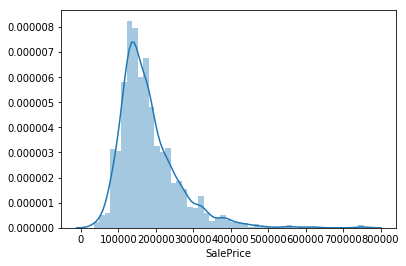

In [8]:
sns.distplot(train_df['SalePrice'])

The restraint house price distribution has a positive deviation, and a few variables have large values, which makes the tail of the curve drag long.
The house price data distribution is steeper than the normal distribution and is a steeple, Slightly different from the normal distribution

In [9]:
print("House price skewness: %g" % train_df['SalePrice'].skew())
print("House price kurtosis: %g" % train_df['SalePrice'].kurt())

House price skewness: 1.88288
House price kurtosis: 6.53628


In [10]:
train_df['SalePrice']=np.log1p(train_df['SalePrice'])

# Data Visualization

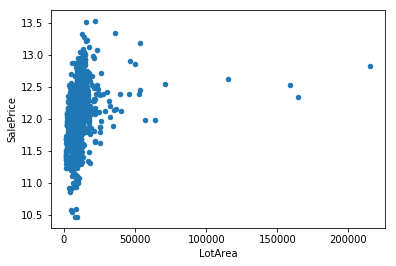

In [11]:
var = 'LotArea'
train_df.plot.scatter(x=var, y='SalePrice')

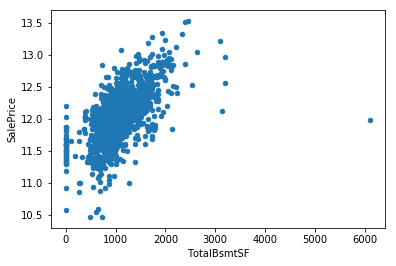

In [12]:
var = "TotalBsmtSF"
train_df.plot.scatter(x=var, y='SalePrice')

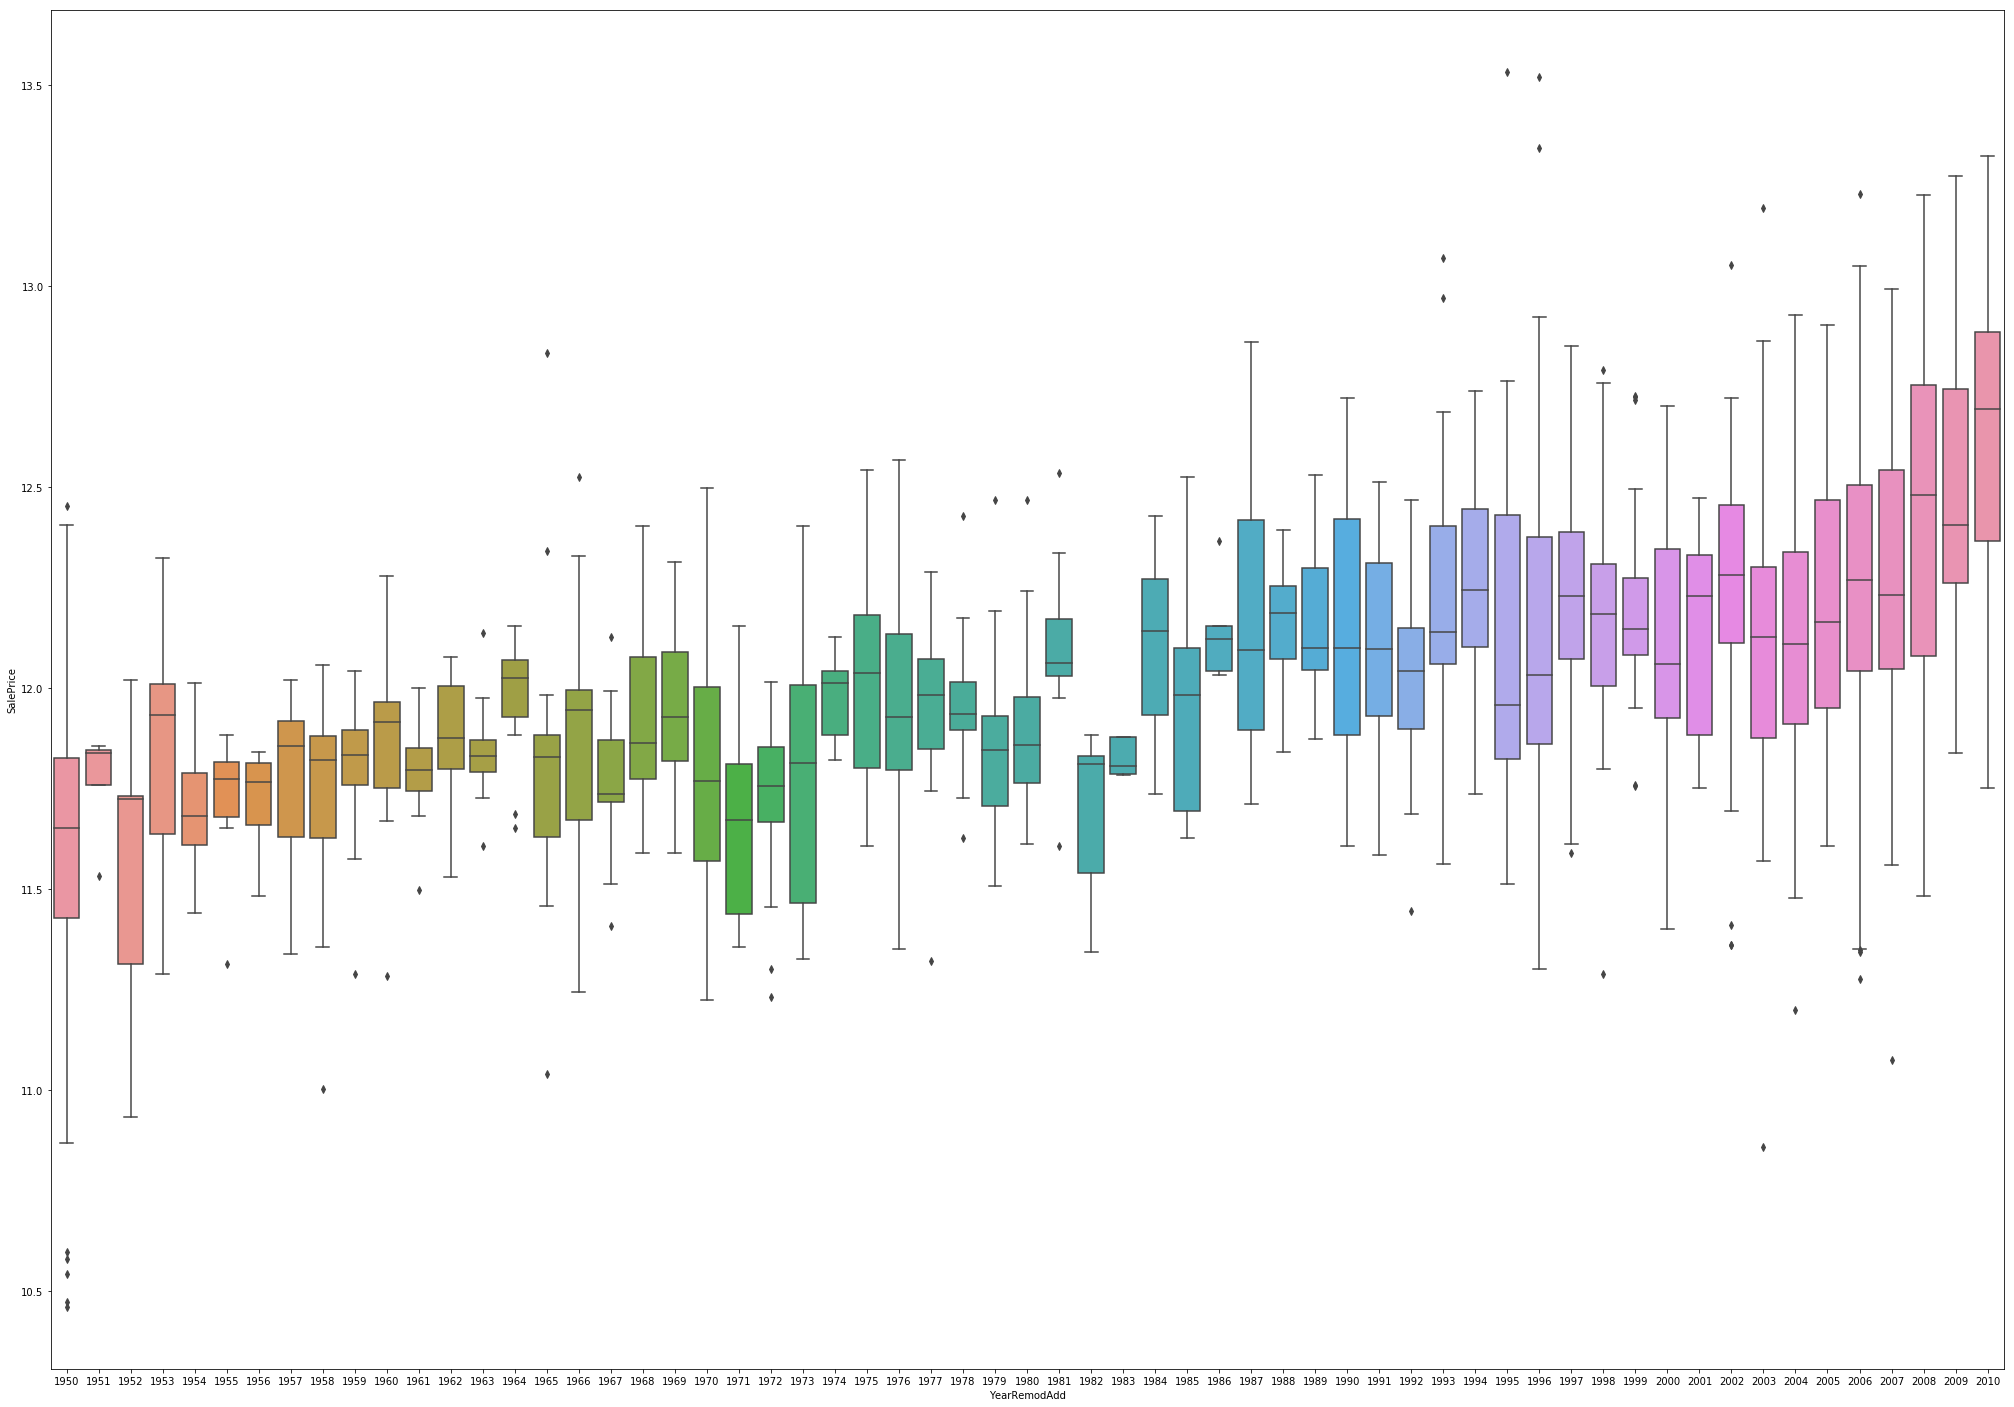

In [13]:
var = "YearRemodAdd"
data = pd.concat([train_df["SalePrice"], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(35, 25))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

From here we can find some abnormal values

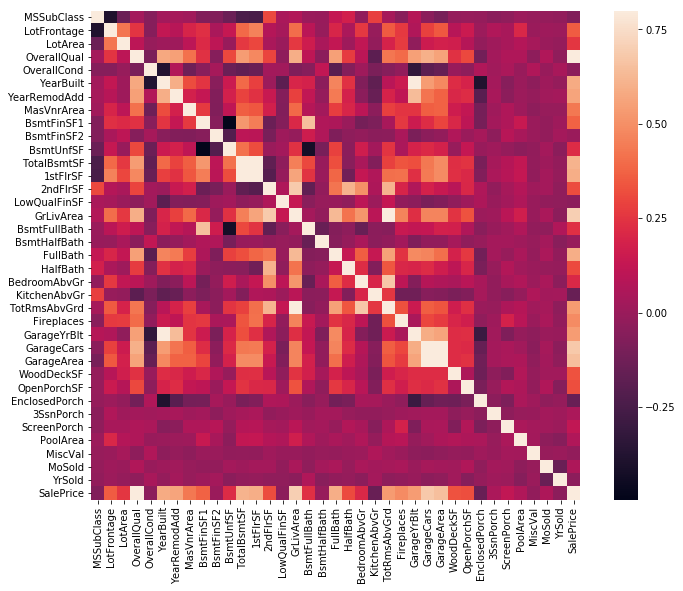

In [14]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

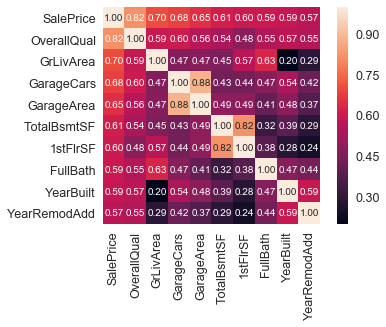

In [15]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].fillna(0).values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

This is the top 10 linear relation factors associate with housing price

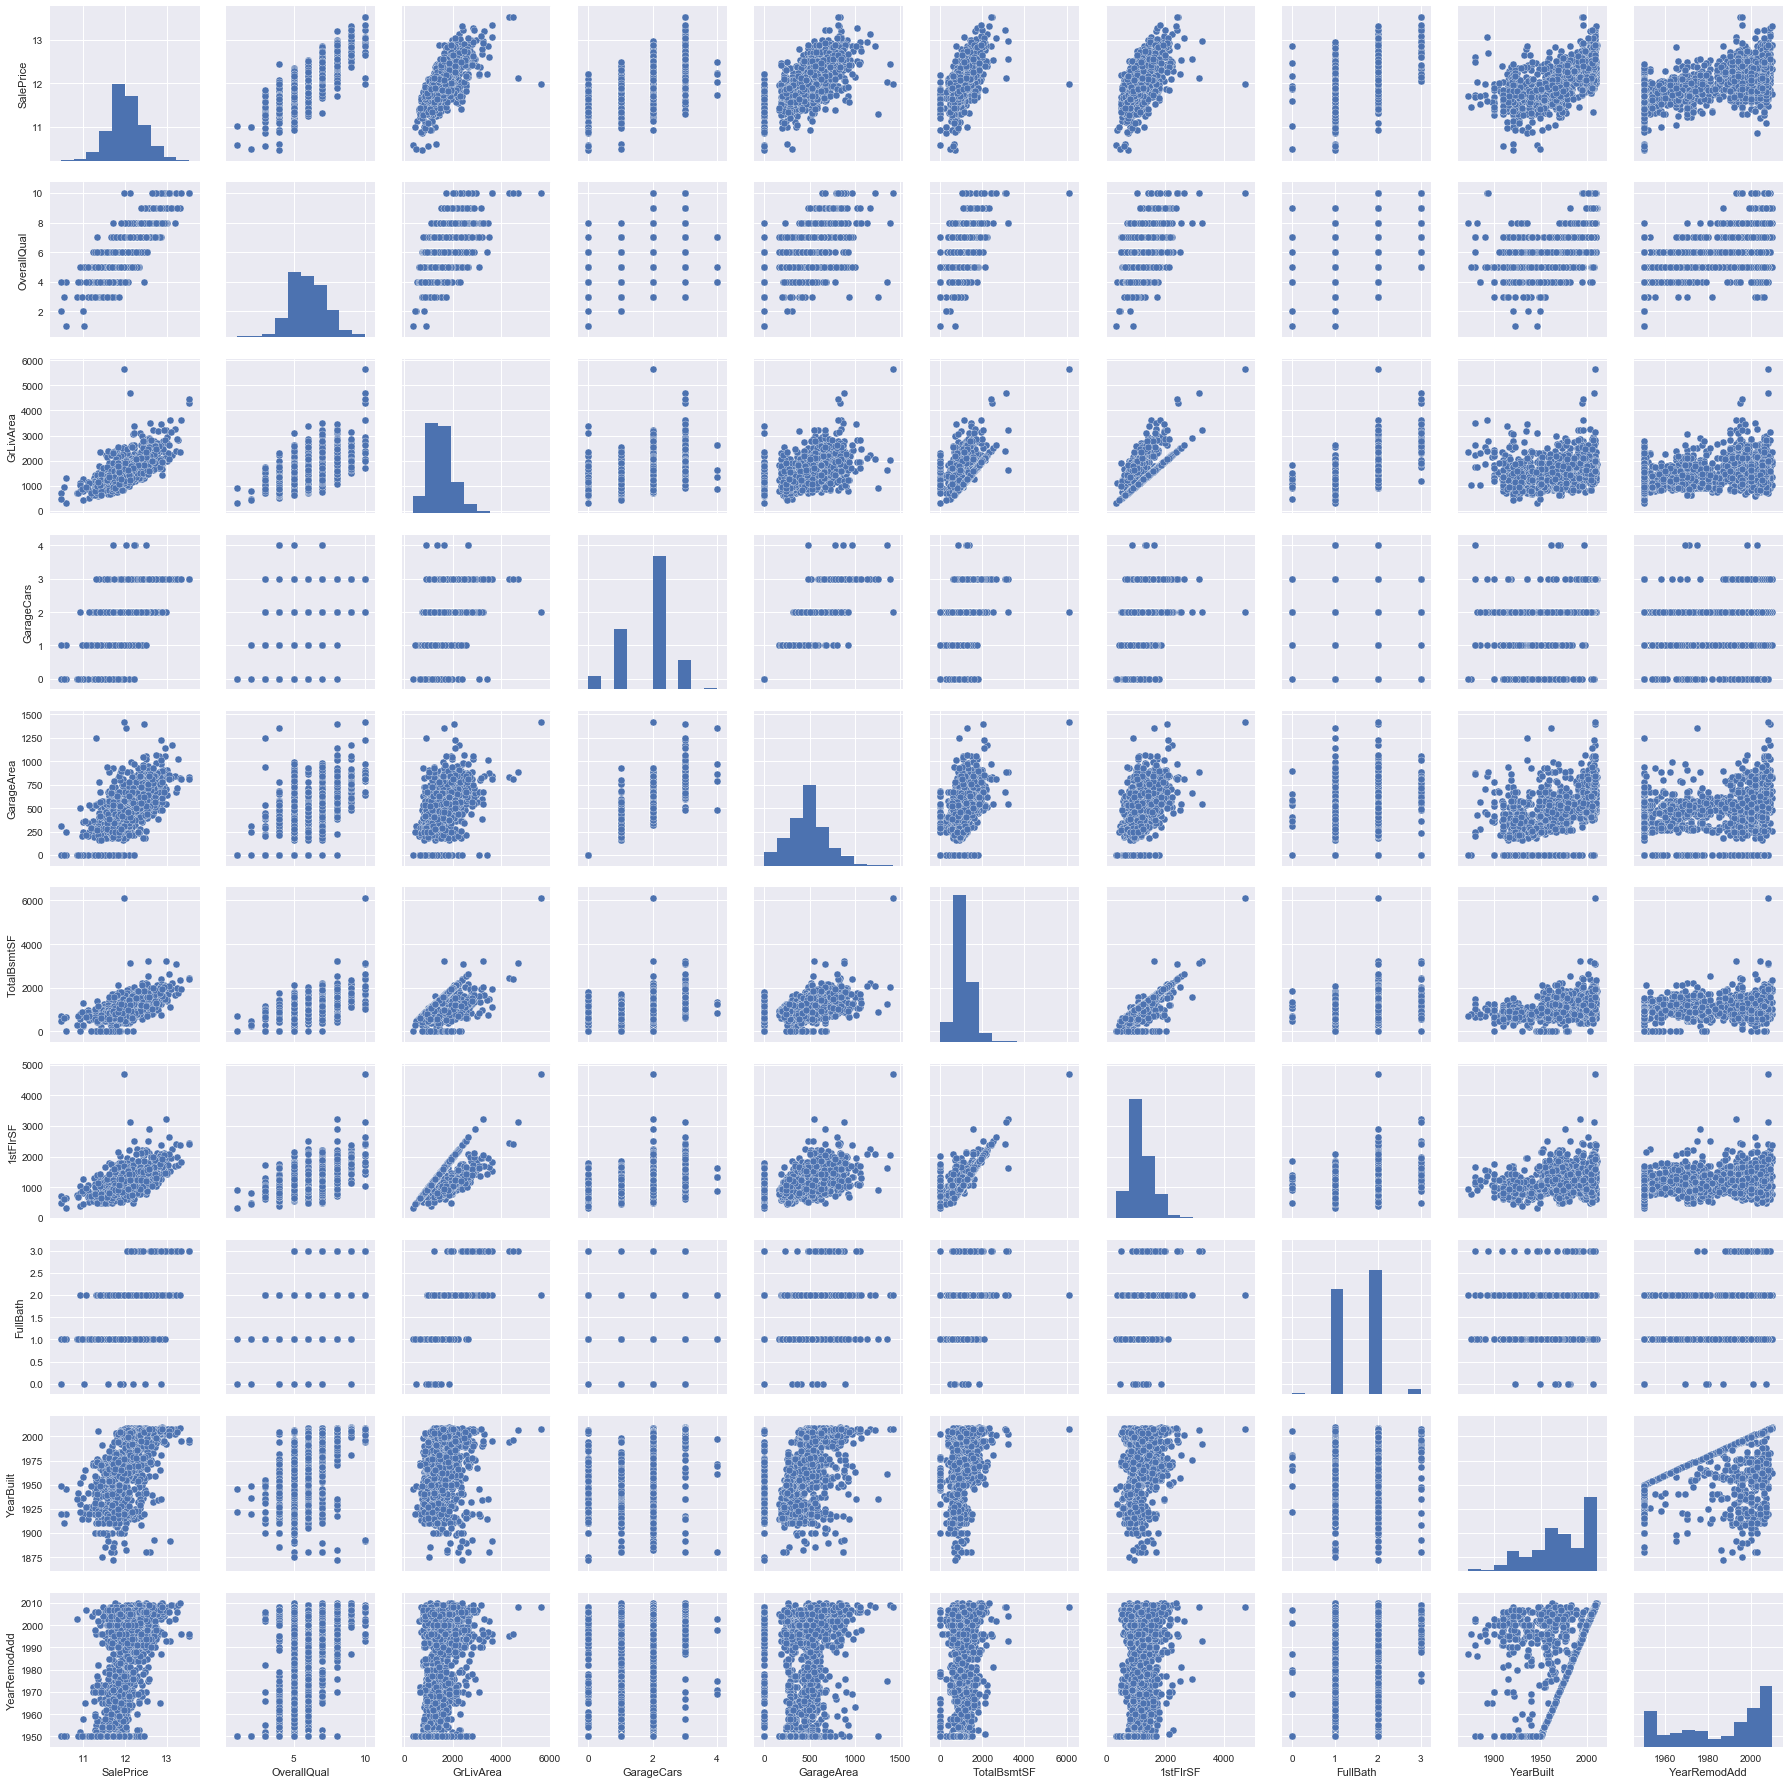

In [16]:
sns.set()
col_name = list(cols)
sns.pairplot(train_df[col_name].fillna(0), size = 2.5)
plt.show()

# Deal with missings

In [17]:
all_df = all_df.fillna(all_df.median())#numerical object median

In [18]:
# character object
feats_object = all_df.dtypes[all_df.dtypes == "object"].index.values

In [19]:
fills={}
for name in feats_object:
    fills[name]=all_df[name].value_counts().index[0]
all_df.fillna(value=fills,inplace=True)

# Convert objects

In [20]:
nf = all_df.dtypes[all_df.dtypes != 'object'].index
sf = all_df[nf].apply(lambda x:stats.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'skew':sf})

In [21]:
skewness = skewness[abs(skewness) > 0.75]
sf = skewness.index
lam = 0.15
for f in sf:
    all_df[f] = special.boxcox1p(all_df[f], lam)

# One-hot recode

In [22]:
df_all_new=pd.get_dummies(all_df)

# Standardization

In [23]:
label=train_df['SalePrice']
clf=RobustScaler()
all_data=clf.fit_transform(df_all_new)
clf_label=RobustScaler()
all_label=clf_label.fit_transform(label.values.reshape(-1,1))

# PCA

In [24]:
pca_clf=PCA(n_components=0.95)
all_data_with_pca=pca_clf.fit_transform(all_data)

In [25]:
all_data_with_pca.shape

(2919, 66)

In [26]:
train=all_data_with_pca[:train_df.shape[0],:]
test=all_data_with_pca[train_df.shape[0]:,:]

In [27]:
model=Ridge()
alpha=[0.1,1,1.5,2,5,10,20,30,40,50]
params={'alpha':alpha}
gs=GridSearchCV(model,param_grid=params,cv=10,verbose=4,n_jobs=-1)#cv is n-fold cross validation,n_jobs is Thread Parallelism
gs.fit(train,all_label)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] .............. alpha=0.1, score=0.9212608793948337, total=   0.0s
[CV] .............. alpha=0.1, score=0.9295037814032546, total=   0.1s
[CV] ............... alpha=0.1, score=0.898399160812529, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=1 .

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s


[CV] alpha=1 .........................................................
[CV] .............. alpha=0.1, score=0.8876742706459223, total=   0.1s
[CV] alpha=1 .........................................................
[CV] .............. alpha=0.1, score=0.7519646475318749, total=   0.2s
[CV] alpha=1.5 .......................................................
[CV] alpha=1.5 .......................................................
[CV] ................ alpha=1, score=0.7521996795058965, total=   0.0s
[CV] .............. alpha=1.5, score=0.9294908360932003, total=   0.0s
[CV] .............. alpha=0.1, score=0.8342865091758945, total=   0.3s
[CV] alpha=1.5 .......................................................
[CV] ................ alpha=1, score=0.8961787762703541, total=   0.1s
[CV] alpha=1.5 .......................................................
[CV] .............. alpha=0.1, score=0.9253860779544654, total=   0.2s
[CV] alpha=1.5 .......................................................
[CV] a

[CV] ............... alpha=30, score=0.8978497713862605, total=   0.0s
[CV] alpha=20 ........................................................
[CV] alpha=50 ........................................................
[CV] alpha=30 ........................................................
[CV] ............... alpha=30, score=0.9236025298639831, total=   0.0s
[CV] ............... alpha=30, score=0.7580078226224558, total=   0.0s
[CV] ............... alpha=30, score=0.8957928871807357, total=   0.0s
[CV] alpha=30 ........................................................
[CV] alpha=30 ........................................................
[CV] alpha=30 ........................................................
[CV] ................ alpha=40, score=0.923924793464785, total=   0.0s
[CV] ............... alpha=20, score=0.9290909309569313, total=   0.0s
[CV] alpha=40 ........................................................
[CV] ............... alpha=40, score=0.9039967316144035, total=   0.0s
[CV] .

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.1, 1, 1.5, 2, 5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [28]:
print(gs.best_score_)
print(gs.best_params_)

0.8859363329546935
{'alpha': 40}


In [29]:
#ridge model
model=Ridge()
alpha=[35,38,40,42,45]
params={'alpha':alpha}
gs=GridSearchCV(model,param_grid=params,cv=10,verbose=4,n_jobs=-1)
gs.fit(train,all_label)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] alpha=35 ........................................................
[CV] alpha=35 ........................................................
[CV] alpha=35 ........................................................
[CV] alpha=35 ........................................................
[CV] ............... alpha=35, score=0.8976608536626963, total=   0.0s
[CV] alpha=35 ........................................................
[CV] ............... alpha=35, score=0.8366358872062758, total=   0.0s
[CV] ............... alpha=35, score=0.9285559127079275, total=   0.0s
[CV] alpha=35 ........................................................
[CV] ............... alpha=35, score=0.9237847358481716, total=   0.0s
[CV] alpha=35 ........................................................
[CV] alpha=35 ........................................................
[CV] ............... alpha=35, score=0.8956201395334057, total=   0.0s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  50 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  50 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [35, 38, 40, 42, 45]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=4)

In [30]:
print(gs.best_score_)
print(gs.best_params_)
model_1=gs.best_estimator_

0.8859393029098032
{'alpha': 38}


In [31]:
model = LinearSVR()
n_estimators=[0.03,0.05,0.1,0.5,1,2,5,10]
params={'C':n_estimators}
gs=GridSearchCV(model,param_grid=params,cv=10,verbose=4,n_jobs=-1)
gs.fit(train,all_label)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ................. C=0.03, score=0.8996035464319709, total=   0.1s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s


[CV] .................. C=0.05, score=0.926879779246548, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ................. C=0.05, score=0.8941826314846324, total=   0.2s
[CV] .................. C=0.05, score=0.826790587679088, total=   0.2s
[CV] ................. C=0.05, score=0.9089015496265914, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ................. C=0.05, score=0.9214421514633705, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ................. C=0.05, score=0.7595697878926011, total=   0.2s
[CV] ................. C=0.05, score=0.8988472998131946, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ................. C=0.05, score=0.8971048487521256, total=   0.2s
[CV] C=0.5 ...........................................................
[CV] C=0.5 ...........................................................
[CV] C

[Parallel(n_jobs=-1)]: Done  36 out of  80 | elapsed:    2.1s remaining:    2.6s


[CV] .................... C=2, score=0.9060706064703236, total=   1.3s
[CV] C=2 .............................................................
[CV] .................... C=1, score=0.8219159862738177, total=   1.2s
[CV] C=5 .............................................................
[CV] .................... C=1, score=0.9332061969869803, total=   1.3s
[CV] C=5 .............................................................
[CV] ..................... C=1, score=0.896675894539566, total=   1.3s
[CV] .................... C=1, score=0.9189890117505157, total=   1.2s
[CV] C=5 .............................................................
[CV] C=10 ............................................................
[CV] .................... C=1, score=0.8944281149868172, total=   1.1s
[CV] ...................... C=2, score=0.89006329798727, total=   1.2s
[CV] C=10 ............................................................
[CV] C=2 .............................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  78 out of  80 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.03, 0.05, 0.1, 0.5, 1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [32]:
print(gs.best_score_)
print(gs.best_params_)
model_2=gs.best_estimator_

0.8870376357688958
{'C': 0.03}


In [33]:
params = {'n_estimators': [1000,2000,3000,4000]}
model = XGBRegressor()
gs=GridSearchCV(model,param_grid=params,cv=10,verbose=4,n_jobs=-1)
gs.fit(train,all_label)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] n_estimators=1000 ...............................................
[CV] n_estimators=1000 ...............................................
[CV] n_estimators=1000 ...............................................
[17:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=1000 ...............................................
[17:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=1000 ...............................................
[17:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=1000 ...............................................
[17:19:19] WARNING: src/objective/regression_obj.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.4s


[CV] ...... n_estimators=1000, score=0.8965407750268781, total=  13.4s
[CV] n_estimators=2000 ...............................................
[17:19:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=3000 ...............................................
[17:19:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=3000 ...............................................
[17:19:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ...... n_estimators=2000, score=0.8844793392226029, total=  29.8s
[CV] n_estimators=3000 ...............................................
[17:19:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ...... n_estimators=2000, score=0.8644628524463761, total=  30.0s
[CV] n_estimators=3000 ................

[Parallel(n_jobs=-1)]: Done  28 out of  40 | elapsed:  1.5min remaining:   39.7s


[CV] ...... n_estimators=3000, score=0.8502888593654386, total=  44.8s
[CV] ...... n_estimators=4000, score=0.8845716191571359, total=  50.7s
[CV] ...... n_estimators=4000, score=0.8643724581281435, total=  51.0s
[CV] ...... n_estimators=4000, score=0.8955234253972569, total=  46.8s
[CV] ...... n_estimators=4000, score=0.7729319548542628, total=  47.0s
[CV] ...... n_estimators=4000, score=0.8409146475465235, total=  41.5s
[CV] ...... n_estimators=4000, score=0.8706732454889498, total=  41.2s
[CV] ...... n_estimators=4000, score=0.8415000869013852, total=  33.1s
[CV] ...... n_estimators=4000, score=0.8838308376750694, total=  33.0s
[CV] ...... n_estimators=4000, score=0.8310231096080157, total=  33.3s
[CV] ...... n_estimators=4000, score=0.8502888550029617, total=  33.5s


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


[17:21:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000, 2000, 3000, 4000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [34]:
print(gs.best_score_)
print(gs.best_params_)

0.853719425992358
{'n_estimators': 1000}


In [35]:
params = {'n_estimators': [100,200,500,800,1000]}
model = XGBRegressor()
gs=GridSearchCV(model,param_grid=params,cv=10,verbose=4,n_jobs=-1)
gs.fit(train,all_label)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[17:21:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=100 ................................................
[17:21:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=100 ................................................
[17:21:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=100 ................................................
[17:21:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] n_estimators=100 ................................................
[17:21:32] WARNING: src/objective/regression_obj.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s


[CV] ........ n_estimators=200, score=0.864606865983629, total=   2.7s
[CV] n_estimators=500 ................................................
[17:21:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ........ n_estimators=200, score=0.881006881484178, total=   2.6s
[CV] n_estimators=500 ................................................
[17:21:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ....... n_estimators=200, score=0.8380020869694484, total=   2.5s
[CV] n_estimators=500 ................................................
[17:21:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ....... n_estimators=200, score=0.8956174349738669, total=   2.6s
[CV] n_estimators=500 ................................................
[17:21:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecate

[Parallel(n_jobs=-1)]: Done  40 out of  50 | elapsed:   22.4s remaining:    5.6s


[CV] ...... n_estimators=1000, score=0.8841273735281486, total=  14.0s
[CV] ...... n_estimators=1000, score=0.8657530881457645, total=  14.1s
[CV] ...... n_estimators=1000, score=0.8965407750268781, total=  12.8s
[CV] ...... n_estimators=1000, score=0.7726804108733495, total=  12.8s
[CV] ....... n_estimators=1000, score=0.841404853624875, total=  10.5s
[CV] ...... n_estimators=1000, score=0.8710386621481566, total=  10.5s
[CV] ...... n_estimators=1000, score=0.8411289693300219, total=   9.8s
[CV] ...... n_estimators=1000, score=0.8834584615980559, total=   9.7s
[CV] ...... n_estimators=1000, score=0.8306517157912645, total=   9.0s
[CV] ...... n_estimators=1000, score=0.8504099498570656, total=   9.1s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.4s finished


[17:22:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 500, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [36]:
print(gs.best_score_)
print(gs.best_params_)
model_3=gs.best_estimator_

0.8547529532807095
{'n_estimators': 500}


In [37]:
class my_model(object):
    def __init__(self,model_list):
        self.model_list=model_list
    def predict(self,test_data):
        ave_pre=0
        for model in self.model_list:
            pre=model.predict(test_data)
            pre=clf_label.inverse_transform(pre.reshape((-1,1)))
            pre=np.expm1(pre)
            ave_pre=ave_pre+pre
        ave_pre=ave_pre/len(self.model_list)
        return ave_pre

In [38]:
model_ave=my_model([model_1,model_2,model_3])

In [39]:
pre=model_ave.predict(test)
out=pd.DataFrame({'Id':test_id,'SalePrice':pre.ravel()})
out.to_csv('final.csv',index=None)